# Regression

### Package & File Setup

In [1]:
# Python ≥3.5 is required, this cell ensures all required packages are imported and a GPU is detected (if available).
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

#if not tf.config.list_physical_devices('GPU'): # GPU detection
#    print("No GPU was detected. CNNs can be very slow without a GPU.")
#    if IS_COLAB:
#        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
#    if IS_KAGGLE:
#        print("Go to Settings > Accelerator and select GPU.")
        

# Common imports
import numpy as np
import os, sys
import pandas as pd
import glob
import cv2
import matplotlib.pyplot as plt
from matplotlib import image
from matplotlib import pyplot
import json
import PIL.Image
import pathlib
import pickle
import random
from tensorflow import keras as K
import h5py
import random
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# To make this notebook's output stable across runs 
np.random.seed(788203)
tf.random.set_seed(788203)
random.seed(788203)

In [4]:
#f1 = h5py.File(r"D:\Datasets\comma\camera\2016-01-30--11-24-51.h5", 'r') 
f1 = h5py.File("./comma/camera/2016-01-30--11-24-51.h5", 'r') 
print(list(f1.keys()))
X1 = f1['X'] # Image arrays
df1= np.array(X1)
print(df1.shape) # 20Hz data rate, images are 160x320.

['X']
(52722, 3, 160, 320)


In [5]:
#f2 = h5py.File(r"D:\Datasets\comma\log\2016-01-30--11-24-51.h5", 'r')
f2 = h5py.File("./comma/log/2016-01-30--11-24-51.h5", 'r')
print(list(f2.keys())) # Vehicle telematics.
y1 = f2['steering_angle'] # Select steering angle.
df2= np.array(y1)
print(df2.shape) # 5 times more data, as data rate is 100Hz.
speed_data = f2['speed'] # Select steering angle.
dfspeed= np.array(speed_data) # To help with future pre-processing
print(df2.shape)

['UN_D_cam1_ptr', 'UN_D_cam2_ptr', 'UN_D_camphone_ptr', 'UN_D_lidar_ptr', 'UN_D_radar_msg', 'UN_D_rawgps', 'UN_T_cam1_ptr', 'UN_T_cam2_ptr', 'UN_T_camphone_ptr', 'UN_T_lidar_ptr', 'UN_T_radar_msg', 'UN_T_rawgps', 'blinker', 'brake', 'brake_computer', 'brake_user', 'cam1_ptr', 'cam2_ptr', 'camphone_ptr', 'car_accel', 'fiber_accel', 'fiber_compass', 'fiber_compass_x', 'fiber_compass_y', 'fiber_compass_z', 'fiber_gyro', 'fiber_temperature', 'gas', 'gear_choice', 'gps_1_fix', 'gps_1_pos', 'gps_1_vel', 'gps_2_fix', 'gps_2_pos', 'gps_2_vel', 'idx', 'imu_accel', 'imu_compass', 'imu_gyro', 'rpm', 'rpm_post_torque', 'selfdrive', 'speed', 'speed_abs', 'speed_fl', 'speed_fr', 'speed_rl', 'speed_rr', 'standstill', 'steering_angle', 'steering_torque', 'times', 'velodyne_gps', 'velodyne_heading', 'velodyne_imu']
(263583,)
(263583,)


### Data Pre-Processing & Exploration

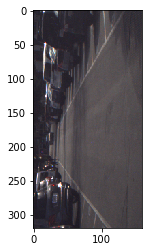

In [6]:
plt.imshow(np.transpose(df1[46948]), interpolation='nearest')
plt.show()

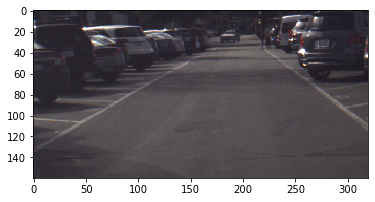

In [7]:
plt.imshow(np.fliplr((np.rot90(np.transpose(df1[46948]), 3))), interpolation='nearest') # Rotate and flip image 
plt.show()

In [8]:
# Find max value
maxval = 0
for i in range(0, len(df2)):
    if df2[i] > maxval:
        maxval = df2[i]
        ind = i
print(ind, maxval)

2901 5011.0


In [9]:
# Make X and y the same length by taking average of every 5 elements in y.
dfv2 = []
dfspeedv2 = []
for i in range(0, len(df1)):
    dfv2.append(sum(df2[i*5: (i*5)+5]) / 5 / 2690.8 / 2) # Find average of every 5 elements, divide by 10 to get angle in degrees
    dfspeedv2.append(sum(dfspeed[i*5: (i*5)+5]) / 5)
print(len(dfv2))

52722


In [10]:
dfv2[6000:-6000]

[0.0022298201278430204,
 0.0022298201278430204,
 0.0022298201278430204,
 0.0022462933043191566,
 0.002285801872799735,
 0.0022298201278430204,
 0.0022298201278430204,
 0.0022298201278430204,
 0.0022298201278430204,
 0.0022298201278430204,
 0.0022298201278430204,
 0.0022477315317744996,
 0.002270397567640383,
 0.002044001783856102,
 0.0019338392463456977,
 0.0013214218512645995,
 0.0009490522273253389,
 0.0009098901701402993,
 0.00046555287716597835,
 0.0002249962852267667,
 0.00018581834398691838,
 5.536982156074352e-05,
 0.0,
 -0.0002598794237868411,
 -0.00037163668797383676,
 -0.00037163668797383676,
 -0.00037163668797383676,
 -0.00037163668797383676,
 -0.00028044308272816905,
 3.320670114540095e-05,
 0.000280331340089589,
 0.000519007352176,
 0.0007432733759476735,
 0.0008721138091294823,
 0.0009290917199345919,
 0.0009290917199345919,
 0.0009290917199345919,
 0.001078755694745895,
 0.0013919353976955507,
 0.0016169003124947043,
 0.0016723650958822653,
 0.0016886554422994,
 0.001911

In [11]:
combined = []

for i in range(0, len(df1)):
    combined.append([np.fliplr((np.rot90(np.transpose(df1[i]), 3))), dfv2[i]])

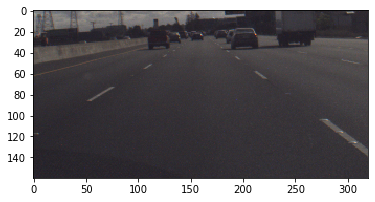

-0.00037163668797383676


In [12]:
index = 29000 # Check images and steering angles
plt.imshow(combined[index][0], interpolation='nearest')
plt.show()
print(combined[index][1])

In [13]:
def clean_data(data, speed_data):
    cleaned = []
    for i in range(0, len(data)):
        if i < 6000: # Initial images removed as driver reverses out of house.
            continue
        if i > (len(data) - 6000): # Final images removed before driver returns to house.
            continue
        if speed_data[i] < 5: # Remove images when car is <5mph, as the view is likely obstructed by car in front/ corner not visible on T-junction.
            continue
        cleaned.append(data[i])
    print(len(cleaned))
    return cleaned

In [14]:
combined_clean = clean_data(combined, dfspeedv2) # Decent number of images, if model performs badly then use more data from other files.

34353


In [15]:
random.shuffle(combined_clean)

### Create Pre-Processing Timeline

In [10]:
def clean_data(data, speed_data):
    cleaned = []
    for i in range(0, len(data)):
        if i < 6000: # Initial images removed as driver reverses out of house.
            continue
        if i > (len(data) - 6000): # Final images removed before driver returns to house.
            continue
        if speed_data[i] < 10: # Remove images when car is <10mph, as the view is likely obstructed by car in front/ corner not visible on T-junction.
            continue
        cleaned.append(data[i])
    print("Length of cleaned data: " + str(len(cleaned)))
    return cleaned

def gen_data(filename):
    
    cam_path = "./comma/camera/.h5"
    log_path = "./comma/log/.h5"
    cam_path = cam_path[:-3] + filename + cam_path[-3:]
    log_path = log_path[:-3] + filename + log_path[-3:]
    
    # Load data (X)
    f1 = h5py.File(cam_path, 'r') 
    print(list(f1.keys()))
    X1 = f1['X'] # Image arrays
    df1= np.array(X1)
    print("X shape: " + str(df1.shape)) # 20Hz data rate, images are 160x320.
    
    # Load data (y)
    f2 = h5py.File(log_path, 'r')
    print(list(f2.keys())) # ALl vehicle telematics.
    y1 = f2['steering_angle'] # Select steering angle.
    df2= np.array(y1)
    print("y shape: " + str(df2.shape)) # 5 times more data, as data rate is 100Hz.
    speed_data = f2['speed'] # Select steering angle.
    dfspeed= np.array(speed_data) # To help with future pre-processing

    # Make X and y the same length by taking average of every 5 elements in y.
    dfv2 = []
    dfspeedv2 = []
    for i in range(0, len(df1)):
        dfv2.append(sum((df2[i*5: (i*5)+5]) / 5 / 10 / 200) + 0.5) # Find average of every 5 elements, divide by 10 to get angle in degrees
        dfspeedv2.append(sum(dfspeed[i*5: (i*5)+5]) / 5)
    print("Length of combined data: " + str(len(dfv2)))
    
    # Combine X and y to make 1 dataframe
    combined = []
    for i in range(0, len(df1)):
        combined.append([np.fliplr((np.rot90(np.transpose(df1[i]), 3))), dfv2[i]])
    print("Data combined")
    
    # Remove start end end data, and stationary data.
    data_clean = clean_data(combined, dfspeedv2)
    print("Data cleaned")
                   
    random.shuffle(data_clean)
    print("Data shuffled")
                          
    return data_clean

def makexy(data):
    X = []
    y = []
    for i in range(0, len(data)):
        X.append(data[i][0])
        y.append(data[i][1])
    X = np.array(X).reshape(-1, 160, 320, 3)  
    y = np.asarray(y).astype('float32').reshape((-1,1))
    return X, y

def max_label(data): # State maximum value of labels
    maxval = 0
    for i in range(0, len(data)):
        if data[i][1] > maxval:
            maxval = data[i][1]
    print("Maximum steering angle: " + str(maxval))
    
def min_label(data): # State minimum value of labels
    minval = 0
    for i in range(0, len(data)):
        if data[i][1] < minval:
            minval = data[i][1]
    print("Minimum steering angle: " + str(minval))

def average_label(data): # State average value of labels
    average = 0
    for i in range(0, len(data)):
        average =+ data[i][1]
    average = average  / len(data)
    print("Average steering angle: " + str(average))

In [42]:
combined_clean_1 = gen_data("2016-01-30--11-24-51")
print()
print()
print()
combined_clean_2 = gen_data("2016-01-30--13-46-00")
print()
print()
print()
combined_clean_3 = gen_data("2016-01-31--19-19-25")
print()
print()
print()
combined_clean_4 = gen_data("2016-02-02--10-16-58")

combined_clean = combined_clean_1 + combined_clean_2 + combined_clean_3 + combined_clean_4
random.shuffle(combined_clean)
print()
print()
print()
print("Length of combined data: " + str(len(combined_clean)))
print()
print()
print()
max_label(combined_clean)
min_label(combined_clean)
average_label(combined_clean)

['X']
X shape: (52722, 3, 160, 320)
['UN_D_cam1_ptr', 'UN_D_cam2_ptr', 'UN_D_camphone_ptr', 'UN_D_lidar_ptr', 'UN_D_radar_msg', 'UN_D_rawgps', 'UN_T_cam1_ptr', 'UN_T_cam2_ptr', 'UN_T_camphone_ptr', 'UN_T_lidar_ptr', 'UN_T_radar_msg', 'UN_T_rawgps', 'blinker', 'brake', 'brake_computer', 'brake_user', 'cam1_ptr', 'cam2_ptr', 'camphone_ptr', 'car_accel', 'fiber_accel', 'fiber_compass', 'fiber_compass_x', 'fiber_compass_y', 'fiber_compass_z', 'fiber_gyro', 'fiber_temperature', 'gas', 'gear_choice', 'gps_1_fix', 'gps_1_pos', 'gps_1_vel', 'gps_2_fix', 'gps_2_pos', 'gps_2_vel', 'idx', 'imu_accel', 'imu_compass', 'imu_gyro', 'rpm', 'rpm_post_torque', 'selfdrive', 'speed', 'speed_abs', 'speed_fl', 'speed_fr', 'speed_rl', 'speed_rr', 'standstill', 'steering_angle', 'steering_torque', 'times', 'velodyne_gps', 'velodyne_heading', 'velodyne_imu']
y shape: (263583,)
Length of combined data: 52722
Data combined
Length of cleaned data: 31741
Data cleaned
Data shuffled



['X']
X shape: (58993, 3, 160,

In [43]:
pickle_out = open("combined_data_random.pickle", "wb") # Save randomised data
pickle.dump(combined_clean, pickle_out)
pickle_out.close()

In [11]:
combined_clean = pickle.load(open("combined_data_random.pickle", "rb")) # Load randomised data

combined_clean = combined_clean[:75000] # Select only 75000 elements from dataset, as more will use more RAM than available.

training_data = combined_clean[:-10000]
validation_data = combined_clean[-20000:-10000]
test_data = combined_clean[-10000:]
X_train, y_train = makexy(training_data)
X_val, y_val = makexy(validation_data)
X_test, y_test = makexy(test_data)

### Create Model

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Input

X_train_norm = X_train/255.0
X_val_norm = X_val/255.0

model = Sequential()

model.add(Input(shape=(160, 320, 3), name="model_input"))

model.add(Conv2D(64, (5, 5))) # Changed
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (5, 5)))

model.add(Conv2D(64, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(256, (3, 3),  name = "visualised_layer"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(512)) # Changed
model.add(Activation('relu')) # Added to reduce overfitting

model.add(Dense(64))
model.add(Activation('relu')) # Added to reduce overfitting

model.add(Dropout(0.5)) # Added to reduce overfitting with recommended p value
model.add(Dense(1, activation = 'linear'))

In [5]:
opt = keras.optimizers.Adam(learning_rate = 0.0001) # Define custom Adam optimiser with different learning rate. 0.000001 did not work
model.compile(loss = 'mean_squared_error', optimizer = opt, metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

In [6]:
model.fit(X_train_norm, y_train, batch_size = 8, epochs = 1000, validation_data = (X_val_norm, y_val), 
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                patience = 5,
                                                restore_best_weights = True)])

Epoch 1/1000
8125/8125 [==============================] - 66s 8ms/step - loss: 0.0077 - rmse: 0.0880 - val_loss: 8.9028e-04 - val_rmse: 0.0298
Epoch 2/1000
8125/8125 [==============================] - 51s 6ms/step - loss: 0.0011 - rmse: 0.0337 - val_loss: 6.1090e-04 - val_rmse: 0.0247
Epoch 3/1000
8125/8125 [==============================] - 51s 6ms/step - loss: 5.1001e-04 - rmse: 0.0226 - val_loss: 7.6198e-04 - val_rmse: 0.0276
Epoch 4/1000
8125/8125 [==============================] - 51s 6ms/step - loss: 3.9450e-04 - rmse: 0.0199 - val_loss: 2.6332e-04 - val_rmse: 0.0162
Epoch 5/1000
8125/8125 [==============================] - 51s 6ms/step - loss: 2.8711e-04 - rmse: 0.0169 - val_loss: 1.3822e-04 - val_rmse: 0.0118
Epoch 6/1000
8125/8125 [==============================] - 51s 6ms/step - loss: 2.3436e-04 - rmse: 0.0153 - val_loss: 1.3377e-04 - val_rmse: 0.0116
Epoch 7/1000
8125/8125 [==============================] - 51s 6ms/step - loss: 2.0786e-04 - rmse: 0.0144 - val_loss: 1.0977e-0

### Evaluation

In [24]:
model.summary() # Showcase layers and parameters of model.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 156, 316, 64)      4864      
                                                                 
 activation (Activation)     (None, 156, 316, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 63, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 59, 64)        102464    
                                                                 
 activation_1 (Activation)   (None, 27, 59, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 29, 64)       0         
 2D)                                                    

In [9]:
X_test_norm = X_test / 255.0

In [30]:
y_pred = model.predict(X_test_norm) # Predict steering angle on test dataset.

In [31]:
y_pred_unproc = (y_pred - 0.5) * 2000 # Remove pre-processing transformations.

In [5]:
model.evaluate(X_test_norm, y_test) # Evaluate model on test set.

313/313 [==============================] - 6s 11ms/step - loss: 4.6059e-05 - rmse: 0.0068


[4.6059212763793766e-05, 0.006786693818867207]

In [14]:
# Find largest predicted steering angle.
maxval = 0
for i in range(0, len(y_pred_unproc)):
    if y_pred_unproc[i] > maxval:
        maxval = y_pred_unproc[i]
        ind = i
print(maxval, ind)

[833.01355] 4211


In [58]:
# Find largest difference between predicted and actual steering angle.
for i in range(0, len(y_pred)):
    if abs(y_pred[i] - y_test[i]) > 0.05:
        maxdif = abs(y_pred[i] - y_test[i])
        ind = i
        print(maxdif, ind)

[0.05494344] 497
[0.10821474] 553
[0.0951978] 1750
[0.0712387] 2970
[0.0715276] 5712
[0.07021803] 6077
[0.13533232] 7001
[0.0650543] 7374
[0.07211635] 8936
[0.06596833] 9254
[0.05564308] 9489
[0.05741492] 9524
[0.06779206] 9706
[0.05816084] 9860


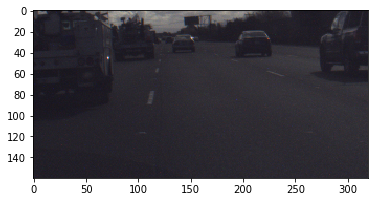

Prediction: [-15.384972]   vs.   Actual: [-12.223363]


In [63]:
index = 6594 # Check images and steering angles.
plt.imshow(X_test[index], interpolation='nearest')
plt.show()
print("Prediction: " + str((y_pred[index] - 0.5) * 2000) + "   vs.   Actual: " + str((y_test[index] - 0.5) * 2000))

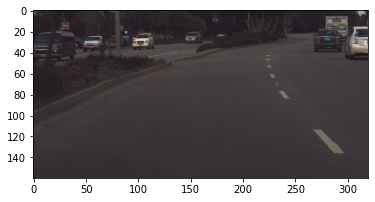

0.5373363342451204


In [34]:
index = 325 # Check images and steering angles.
plt.imshow(combined_clean[index][0], interpolation='nearest')
plt.show()
print(combined_clean[index][1])

In [48]:
min_label(test_data)

Minimum steering angle: 0


In [58]:
std = np.std(y_test)
std

0.025550336

### Save Model

In [62]:
model.save("Regression") # Save model.

INFO:tensorflow:Assets written to: Regression/assets


### Load Model

In [4]:
model = keras.models.load_model("Regression") # or add the path